# Does The S&P Really Make You Rich?
I have seen many posts on social media suggesting anyone can get rich by simply investing a little money in the S&P500 and just letting the average annualized returns of around 8-9% make you a millionaire by sitting back and letting compound interest do the work. I decided to have a little deeper look into this to see if this is the case or is it just social media hype.

### Download S&P 500 Data

To start with we need to get the historical data for the S&P 500. There are many solutions out there, but I was reading the Wikipedia article about the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) and there is a rather decent table showing the annual price change since 1970. To get this data we can use the python requests and Beautiful Soup libraries to pull the data and pandas to load the data into a useable data frame.  Before we do this let us import the libraries we will be needing.

In [1]:
import random
import requests
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
res = requests.get("https://en.wikipedia.org/wiki/S%26P_500").text
soup = BeautifulSoup(res, 'html.parser')
df = pd.read_html(str(soup.find('table', {'class': "wikitable"})))[
    0].head(-4)  # remove last few lines of text
df = df[['Year', 'Change in Index']]
df.tail()

,Year,Change in Index
46,2016,9.54%
47,2017,19.42%
48,2018,−6.24%
49,2019,28.88%
50,2020,16.26%


### Data Wrangling
There are a couple of issues with the data, the Wikipedia table contains strings with percent symbols and invalid negative signs for parsing into a float. These can both be fixed by using some simple string manipulation.

In [4]:
def string_to_float(string: str) -> float:
    if string.endswith("%"):
        string = string[:-1]
    string = string.replace("−", "-")
    return float(string)

In [5]:
df['Change in Index'] = df['Change in Index'].apply(string_to_float)

### Look at the Returns Of Pure Compound Interest

Let's have a quick look to see what we should expect!

In [6]:
print(f"Mean annual return: {df['Change in Index'].mean():.02f}%")
print(f"Median annual return: {df['Change in Index'].median():.02f}%")

Mean annual return: 8.90%
Median annual return: 12.31%


So if we invested $1,000 for 30 years we would expect to get just under $13,000 at the end. That is a pretty decent return and if you can put enough money in initially you should be rather wealthy in retirement.

In [7]:
print(
    f"30 year compounded value: ${1000*(1+df['Change in Index'].mean()/100)**30:,.02f}")

30 year compounded value: $12,889.91


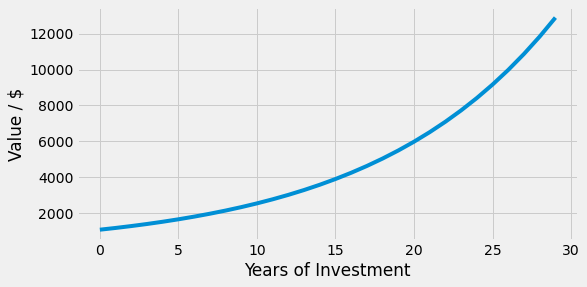

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot([1000*(1+df['Change in Index'].mean()/100)**i for i in range(1, 31)])
ax.set_ylabel('Value / $')
ax.set_xlabel('Years of Investment')

### Use Actual Yearly Historical Returns to Forecast The Future

Clearly, the above result is very impressive and shows the power of compound interest, but what if instead of just taking the average return we created a forecast based upon randomly selecting from historical data? To do this we can take the returns for each year from our panda's data frame and convert this to a list. Then we can randomly select 30 years' worth of returns from this historical list. Depending on our random choices we will get very different outcomes. So initially we will do give runs to see the spread.

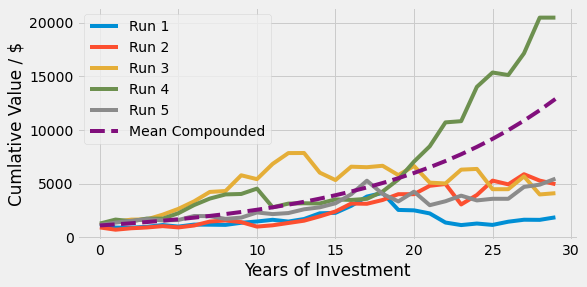

In [78]:
historical_values = (1+df['Change in Index']/100).tolist()
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(5):
    ax.plot(np.cumprod(random.choices(historical_values, k=30))
            * 1000, label=f"Run {i+1}")
ax.plot([1000*(1+df['Change in Index'].mean()/100) **
        i for i in range(1, 31)], label='Mean Compounded', linestyle='--')
ax.set_ylabel('Cumlative Value / $')
ax.set_xlabel('Years of Investment')
ax.legend()

Looking at the figure above we have quite a range of results if we actually use historical data and not just assume the average return each year. These results are not as promising as we have been led to believe with four-of-five well underperforming the predicted return. We randomly selected 5 as a magic number and should proceed with many run to see the distribution in outcomes.

In [11]:
one_thousand_attempts = [np.prod(random.choices(
    historical_values, k=30))*1000 for i in range(1000)]

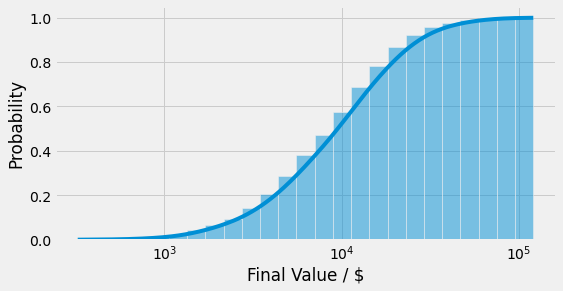

In [58]:
fig, ax = plt.subplots(figsize=(8, 4))
hist = sns.histplot(one_thousand_attempts, ax=ax, cumulative=True,
                    kde=True, log_scale=True, stat='probability')
hist.set(xlabel='Final Value / $');

So how can we interpret the results above? Let us have a look at what proportion came in below that of the simple compound interest case.

In [95]:
print(
    f"Probaility of getting less than simple compound interest: \
{sp.stats.percentileofscore(one_thousand_attempts, 1000*(1+df['Change in Index'].mean()/100)**30)}%")

Probaility of getting less than simple compound interest: 64.5%


Using this rather simple method from scipy we can determine that nearly two-thirds of the time we would expect to see a return less than expected from the pure compound interest model.

In [93]:
df_quantiles = pd.DataFrame.from_dict(
    [{'Quantile': i/10, 'Final Value': np.quantile(one_thousand_attempts, i/10)} for i in range(1, 11)])
df_quantiles['Final Value'] = df_quantiles['Final Value'].apply(lambda x: f"${x:,.02f}")

In [94]:
df_quantiles

,Quantile,Final Value
0,0.1,"$2,802.99"
1,0.2,"$4,293.12"
2,0.3,"$5,815.19"
3,0.4,"$7,601.04"
4,0.5,"$9,721.23"
5,0.6,"$11,711.69"
6,0.7,"$14,720.17"
7,0.8,"$19,003.83"
8,0.9,"$26,678.24"
9,1.0,"$120,619.61"


Looking at this table and the cumulative plot we can see that there is a very real probability of a much lower return than the pure compound interest model suggests $12,889.91. On the flip side, there is also a chance, albeit much smaller, that you could earn much more than expected. Overall I hope this rather simple model highlights that although compound interest may be the 8th wonder of the world, the reality of investing involves a lot of variability and a range of possible outcomes.

This article is available as a notebook on my (GitHub)[https://github.com/blockchain-panda], so feel free to download and have a play.